<a href="https://colab.research.google.com/github/Manditar2/NLI-con-red-neuronal-LSTM/blob/main/Proyecto_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences
from keras.callbacks import TensorBoard, EarlyStopping
from keras.layers import Input, Embedding, LSTM , Dense, Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D
from keras.metrics import TruePositives, FalsePositives,categorical_accuracy, TrueNegatives, FalseNegatives, Precision, Recall, AUC



In [ ]:
nltk.download('stopwords')
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


--2023-06-04 15:07:08--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-04 15:07:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-06-04 15:09:48 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [ ]:
#@title Cargar datos
df = pd.read_csv('/content/sample_data/snli_1.0_train.csv')
columnas = ['sentence1','sentence2','gold_label']
df = df[columnas]
df.dropna(axis=0, inplace=True) #Se eliminan datos nulos
df.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [ ]:
df.shape

(550146, 3)

In [ ]:

df.shape

(550146, 3)

In [ ]:
df = df.loc[df['gold_label'] != "-"]   #Se botan las filas que contengan - y neutral
df = df.loc[df['gold_label'] != "neutral"]
df.head()

,sentence1,sentence2,gold_label
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
4,Children smiling and waving at camera,There are children present,entailment
5,Children smiling and waving at camera,The kids are frowning,contradiction
6,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,contradiction


In [ ]:
df = df.sample(frac = 1)
df["gold_label"] = (df["gold_label"] == "contradiction").astype(int)
len(df)

366599

In [ ]:
y = df['gold_label']
len(df)
X = df[['sentence1','sentence2']]

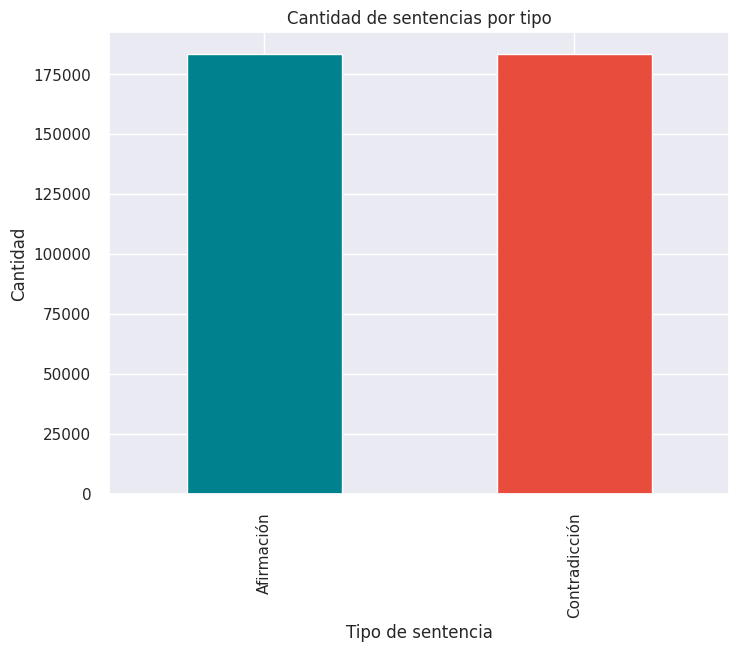

In [ ]:
sns.set(style='darkgrid')
colores = ['#00818E', '#e74c3c']
counts = df['gold_label'].value_counts().rename({0: 'Afirmación', 1: 'Contradicción'})

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color = colores)
plt.title('Cantidad de sentencias por tipo')
plt.xlabel('Tipo de sentencia')
plt.ylabel('Cantidad')
plt.show()

In [ ]:
#@title Limpieza de datos

def limpiarTexto(texto):
  texto = str(texto).lower()
  texto = re.sub('\[.*?\]', '', texto)
  texto = re.sub('<.*?>+', '', texto)
  texto = re.sub('\n', '', texto)
  texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)
  texto = re.sub('\w*\d\w*', '', texto)
  return texto
  # sentences = sentences.apply(lambda sequence:
  #                                           [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  # sentences = sentences.apply(lambda wrd: ''.join(wrd))
  # sentences = sentences.apply(lambda sequence:
  #                                           [word for word in sequence.split() if word not in stop_words])
  # sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  # return sentences
df.head()

,sentence1,sentence2,gold_label
492309,Bikers in a bike race take a sharp left turn.,people are riding bikes,0
478349,Two men play a cello and a guitar as a woman s...,A rock band is playing a Carnigie hall.,1
448501,Man in a blue shirt sleeping in a recliner.,A woman does jumping jacks in the living room,1
361750,A young boy is in the middle of playing ping-p...,A young girl is playing ping pong.,1
73649,Two Rubbish men standing on their truck loadin...,Two Rubbish men look for food in the trash.,1


In [ ]:
df['sentence1'] = df['sentence1'].apply(limpiarTexto)
df['sentence2'] = df['sentence2'].apply(limpiarTexto)
# sentencia1 = limpiarTexto(df['sentence1'])
# sentencia2 = limpiarTexto(df['sentence2'])
# sentencia1
df.head()

,sentence1,sentence2,gold_label
492309,bikers in a bike race take a sharp left turn,people are riding bikes,0
478349,two men play a cello and a guitar as a woman s...,a rock band is playing a carnigie hall,1
448501,man in a blue shirt sleeping in a recliner,a woman does jumping jacks in the living room,1
361750,a young boy is in the middle of playing pingpong,a young girl is playing ping pong,1
73649,two rubbish men standing on their truck loadin...,two rubbish men look for food in the trash,1


In [ ]:
#@title Pre procesamiento
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
  
df['sentence1'] = df['sentence1'].apply(remove_stopwords)
df['sentence2'] = df['sentence2'].apply(remove_stopwords)
df.head()


,sentence1,sentence2,gold_label
492309,bikers bike race take sharp left turn,people riding bikes,0
478349,two men play cello guitar woman sings lettere ...,rock band playing carnigie hall,1
448501,man blue shirt sleeping recliner,woman jumping jacks living room,1
361750,young boy middle playing pingpong,young girl playing ping pong,1
73649,two rubbish men standing truck loading trash,two rubbish men look food trash,1


In [ ]:
stemmer = nltk.SnowballStemmer('english')
def stematizar(texto):
  texto = ' '.join(stemmer.stem(word) for word in texto.split(' ')) #Divide el texto, y aplica la función de stematización a cada palabra
  return texto
# df['sentence1'] = df['sentence1'].apply(stematizar)
# df['sentence2'] = df['sentence2'].apply(stematizar)
premisa = df['sentence1']
hipotesis = df['sentence2']
premisa

492309                bikers bike race take sharp left turn
478349    two men play cello guitar woman sings lettere ...
448501                     man blue shirt sleeping recliner
361750                    young boy middle playing pingpong
73649          two rubbish men standing truck loading trash
                                ...                        
481111                           woman sitting reading book
49692         woman purple shirt white skirt playing tennis
441688               man pasture front cross plaque reading
504804              air traffic controllers watching runway
158394    two climbers attempting climb steep snowcovere...
Name: sentence1, Length: 366599, dtype: object

In [ ]:
#@title Tokenización
sentencias_arreglo = np.asarray([premisa,hipotesis])
print(sentencias_arreglo)
sentencias_arreglo = sentencias_arreglo.reshape(-1,1)

[['bikers bike race take sharp left turn'
  'two men play cello guitar woman sings lettere caffe'
  'man blue shirt sleeping recliner' ...
  'man pasture front cross plaque reading'
  'air traffic controllers watching runway'
  'two climbers attempting climb steep snowcovered peak nearing top two climbers await']
 ['people riding bikes' 'rock band playing carnigie hall'
  'woman jumping jacks living room' ... 'man outside looking something'
  'people watching runway' 'two climbers working complete feat']]


In [ ]:
sentencias_arreglo.shape

(733198, 1)

In [ ]:
print(sentencias_arreglo)

[['bikers bike race take sharp left turn']
 ['two men play cello guitar woman sings lettere caffe']
 ['man blue shirt sleeping recliner']
 ...
 ['man outside looking something']
 ['people watching runway']
 ['two climbers working complete feat']]


In [ ]:
sentencias_arreglo = sentencias_arreglo.reshape(sentencias_arreglo.shape[0])
sentencias_arreglo.shape

(733198,)

In [ ]:
sentencias_arreglo

array(['bikers bike race take sharp left turn',
       'two men play cello guitar woman sings lettere caffe',
       'man blue shirt sleeping recliner', ...,
       'man outside looking something', 'people watching runway',
       'two climbers working complete feat'], dtype=object)

In [ ]:
tokenizar = Tokenizer(num_words = 6000)
tokenizar.fit_on_texts(sentencias_arreglo) #Transforma a "número" las palabras dentro del arreglo


In [ ]:
premisa = tokenizar.texts_to_sequences(premisa) #Guarda un arreglo que en vez de palabras, posee índices de palabras
premisa = pad_sequences(premisa) #Agrega padding para estandarizar el tamaño
hipotesis_seq = tokenizar.texts_to_sequences(hipotesis)
hipotesis = pad_sequences(hipotesis_seq, maxlen = premisa.shape[1])
print(hipotesis)

[[   0    0    0 ...    3   36  293]
 [   0    0    0 ...  153    8 1186]
 [   0    0    0 ... 2772  594  126]
 ...
 [   0    0    0 ...   20   32   73]
 [   0    0    0 ...    3   67 4243]
 [   0    0    0 ... 2009   60 2465]]


In [ ]:
print(hipotesis[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   3  36 293]


In [ ]:
print(premisa[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 1023   55  149  380 2872  327
  871]


In [ ]:
encoder = LabelEncoder()
etiquetas = df['gold_label']
etiquetas = encoder.fit_transform(etiquetas)
etiquetas

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
etiquetas = to_categorical(etiquetas)
etiquetas

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
etiquetas.shape

(366599, 2)

In [ ]:
premisa.shape

(366599, 43)

In [ ]:
hipotesis.shape

(366599, 43)

In [ ]:
data_tokenizada = np.asarray([premisa,hipotesis])
data_tokenizada

array([[[   0,    0,    0, ..., 2872,  327,  871],
        [   0,    0,    0, ...,  107,    2,  624],
        [   0,    0,    0, ...,   12,   77, 3769],
        ...,
        [   0,    0,    0, ...,  501, 5980,  144],
        [   0,    0,    0, ...,  596,   67, 4243],
        [   0,    0,    0, ...,    4, 2009, 3422]],

       [[   0,    0,    0, ...,    3,   36,  293],
        [   0,    0,    0, ...,  153,    8, 1186],
        [   0,    0,    0, ..., 2772,  594,  126],
        ...,
        [   0,    0,    0, ...,   20,   32,   73],
        [   0,    0,    0, ...,    3,   67, 4243],
        [   0,    0,    0, ..., 2009,   60, 2465]]], dtype=int32)

In [ ]:
data_tokenizada.shape

(2, 366599, 43)

In [ ]:
data_tokenizada = data_tokenizada.reshape(data_tokenizada.shape[1], 2, data_tokenizada.shape[2])

In [ ]:
data_tokenizada.shape

(366599, 2, 43)

In [ ]:
len(tokenizar.word_index)

29710

In [ ]:
#@title Embedding
vocabulario = len(tokenizar.word_index)

def gloveWork(archivo,vocabulario):
  #Se crea un diccionario palabra-vector de un modelo preentrenado(Glove)
  embeddings_index = {}
  file_ = open(archivo)
  for line in file_:
      arr = line.split()
      palabra = arr[0]
      vector = np.asarray(arr[1:],dtype='float32')
      embeddings_index[palabra] = vector
  file_.close() 

  tam_maximo = vocabulario +1
  indices_palabras = tokenizar.word_index
  embedding_matriz = np.zeros((tam_maximo,300)).astype(object)

  for palabrax, indice in indices_palabras.items():
    vector_entrenado = embeddings_index.get(palabrax)
    print(palabrax)
    if vector_entrenado is not None:
      embedding_matriz[indice] = vector_entrenado

  return embedding_matriz


In [ ]:
gloveWork("glove.6B.300d.txt", vocabulario)

Se han truncado las últimas 5000 líneas del flujo de salida.
hoket
hogwarts
tralier
widdling
drining
villa
unappealing
forign
wedges
chuckles
samuel
rosanne
barr
palayer
frenches
interments
perceives
wlaking
teetotalers
velociraptor
arenas
aritist
saudi
arabia
sidewalke
deloreon
roomusing
paiting
basketaball
brusing
squeaking
threepiecesuit
affectionatly
guzzle
everclear
beavers
seriouslooking
arounding
resignation
pictrues
nearsighted
midrink
pid
crwd
rummi
surprising
personss
musicina
cire
redsox
pele
standin
frankfurter
mesuring
squeal
fived
plankton
proclaims
obstruction
leaguers
atletes
uptown
preists
graspes
restauant
ecuador
parliamentary
jerked
smirked
neighs
withdram
communicated
horsegot
reticle
django
unchained
puchas
higerise
instrament
boya
guar
vultures
reese
witherspoon
thoman
sinbad
atypical
communicator
snusnu
trend
pundome
sorrounded
scamming
majic
cockatoo
yesteryear
shuffle
protrait
skateboared
officiating
billards
speedwalking
wilted
staniding
alluring
liesure
skyp

array([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [-0.2978399991989136, -0.13255000114440918, -0.14505000412464142,
        ..., 0.27612999081611633, -0.2831999957561493,
        0.5055400133132935],
       [-0.5182099938392639, -0.13808999955654144, -0.4118500053882599,
        ..., 0.37342000007629395, -0.03016600012779236,
        0.730139970779419],
       ...,
       [-0.09578099846839905, -0.14733000099658966, 0.4487900137901306,
        ..., 0.302839994430542, 0.613789975643158, -0.36809998750686646],
       [-0.10569000244140625, 0.35624998807907104, 0.08958700299263, ...,
        -0.10752999782562256, 0.985480010509491, 0.11202000081539154],
       [-0.3469499945640564, -0.1106799989938736, -0.29802000522613525,
        ..., -0.024243999272584915, -0.19544999301433563,
        -0.16419999301433563]], dtype=object)

In [ ]:
#@title Modelo
x = Input(shape=(data_tokenizada.shape[1], data_tokenizada.shape[2],))
p = TimeDistributed(Embedding(vocabulario + 1 , 300))(x)
p = TimeDistributed(LSTM(128, return_sequences=True))(p)
p = TimeDistributed(LSTM(64, return_sequences=True))(p)
x1 = TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(p)
x2 = TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(p)
concat = tf.keras.layers.concatenate([x1, x2])
p = tf.keras.layers.Dropout(0.5)(concat)
p = Flatten()(p)
p = Dense(2, activation="softmax")(p)

In [ ]:
m = tf.keras.models.Model(inputs = x, outputs = p)

In [ ]:
m.layers[1].set_weights([gloveWork("glove.6B.300d.txt", vocabulario)])
m.layers[1].trainable = False

In [ ]:
m.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2, 43)]      0           []                               
                                                                                                  
 time_distributed_10 (TimeDistr  (None, 2, 43, 300)  8913300     ['input_3[0][0]']                
 ibuted)                                                                                          
                                                                                                  
 time_distributed_11 (TimeDistr  (None, 2, 43, 128)  219648      ['time_distributed_10[0][0]']    
 ibuted)                                                                                          
                                                                                            

In [ ]:
m.compile(loss="binary_crossentropy",optimizer='Adam',metrics=[TruePositives(name='tp'),
                                                                     FalsePositives(name='fp'),
                                                                     TrueNegatives(name='tn'),
                                                                     FalseNegatives(name='fn'),
                                                                     "accuracy",
                                                                     Precision(name='precision'),
                                                                     Recall(name='recall'),
                                                                     AUC(name = "AUC")])


In [ ]:
earlyStopping = EarlyStopping(monitor = 'loss', patience = 60, mode = 'min', restore_best_weights = True)

In [ ]:
history_training = m.fit(data_tokenizada,etiquetas,
                         epochs= 200,
                         batch_size = 1024,
                         use_multiprocessing=True,
                         workers=-1,
                         callbacks=[earlyStopping])

Epoch 1/200
287/359 [======================>.......] - ETA: 4s - loss: 0.3355 - tp: 235688.0000 - fp: 58200.0000 - tn: 235688.0000 - fn: 58200.0000 - accuracy: 0.8020 - precision: 0.8020 - recall: 0.8020 - AUC: 0.9134

KeyboardInterrupt: ignored

In [ ]:
import matplotlib as mpl
def draw_plot(data,c, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (20, 6))
  plt.plot(data,c, label= type_data)
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()


<ipython-input-205-235b6aa75655>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


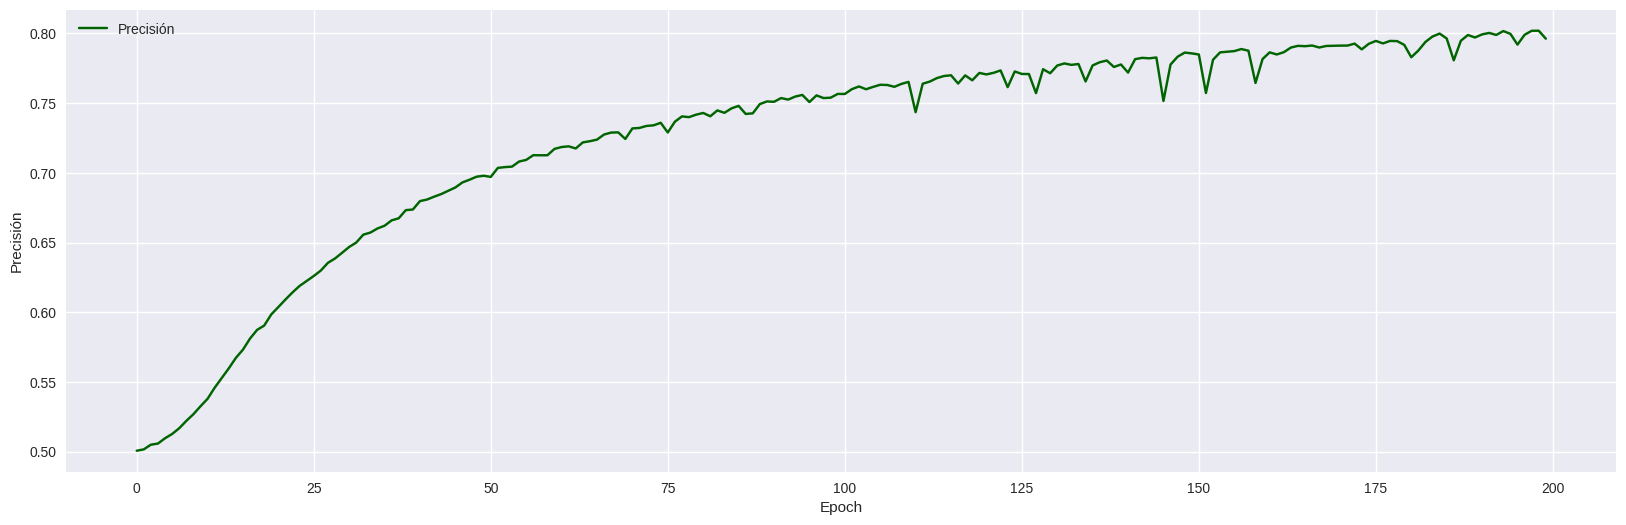

In [ ]:
draw_plot(history_training.history['accuracy'],"darkgreen", "Precisión")

<ipython-input-205-235b6aa75655>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


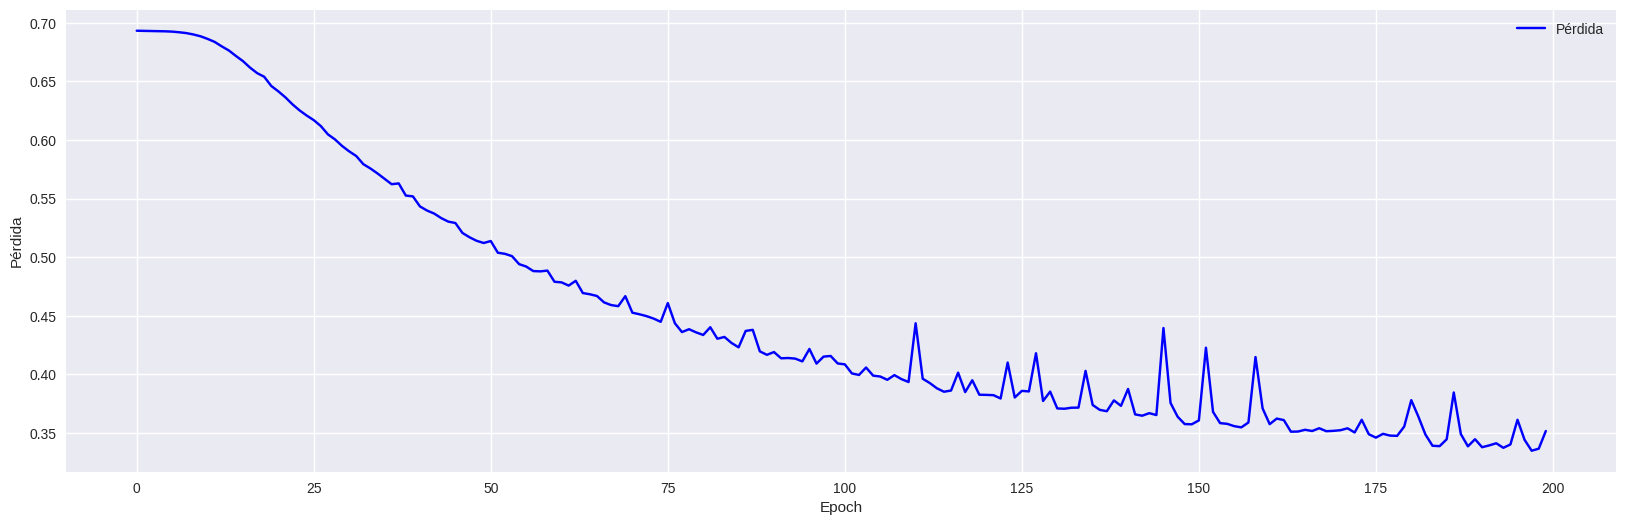

In [ ]:

draw_plot(history_training.history['loss'],"blue", "Pérdida")

<ipython-input-205-235b6aa75655>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


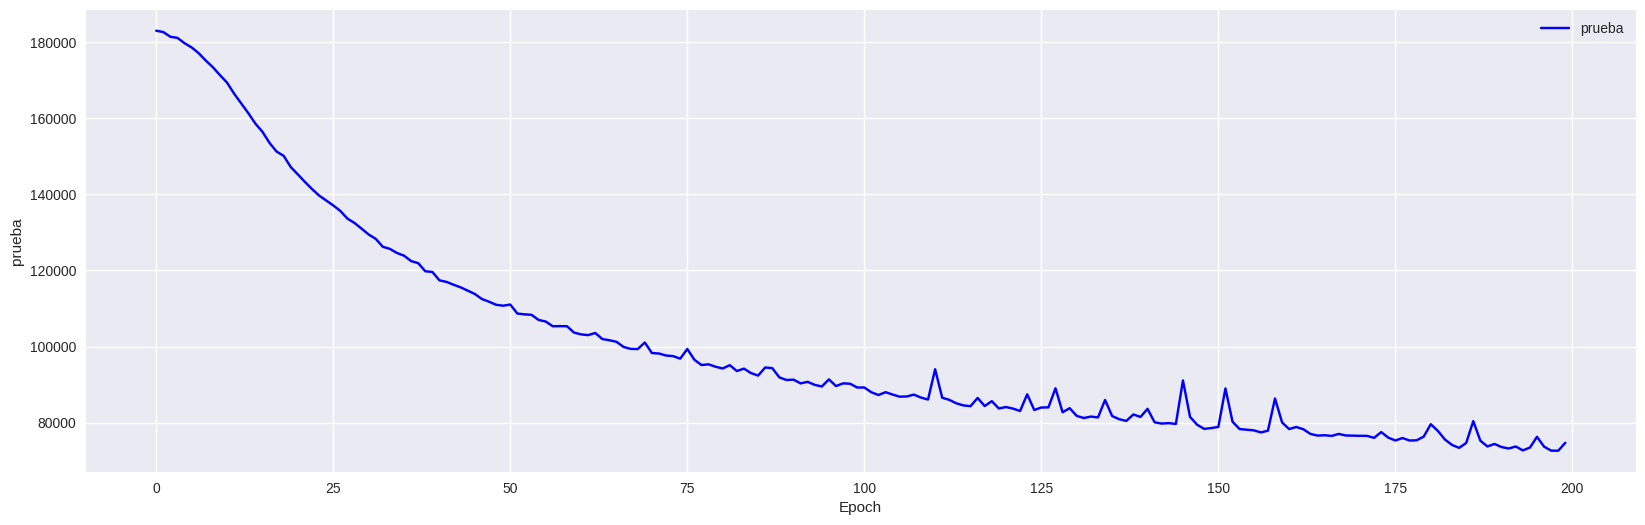

In [ ]:
draw_plot(history_training.history['fn'],'blue','prueba')

In [ ]:
#@title Cargar datos de prueba
df_prueba = pd.read_csv('/content/sample_data/snli_1.0_train.csv')
columnas_prueba = ['sentence1','sentence2','gold_label']
df_prueba = df_prueba[columnas_prueba]
df_prueba.dropna(axis=0, inplace=True) #Se eliminan datos nulos
df_prueba.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [ ]:
df_prueba = df_prueba.loc[df_prueba['gold_label'] != "-"]   #Se botan las filas que contengan - y neutral
df_prueba = df_prueba.loc[df_prueba['gold_label'] != "neutral"]
df_prueba.head()

,sentence1,sentence2,gold_label
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
4,Children smiling and waving at camera,There are children present,entailment
5,Children smiling and waving at camera,The kids are frowning,contradiction
6,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,contradiction


In [ ]:
df_prueba = df_prueba.sample(frac = 1)
df_prueba["gold_label"] = (df_prueba["gold_label"] == "contradiction").astype(int)
df_prueba.head()

,sentence1,sentence2,gold_label
407064,A woman in a black shirt and blue jeans is run...,The woman is sitting down.,1
435994,The baby is mesmerized and intrigued by his im...,A group of dogs are playing cards at a table.,1
47009,A dog fetching an orange ball in the water.,A dog is retrieving an item.,0
298209,"Two men, one in a blue uniform and one in a re...",People are sleeping.,1
146854,This is a group of young adults at a party and...,There is a party.,0


In [ ]:
df_prueba['sentence1'] = df_prueba['sentence1'].apply(limpiarTexto)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(limpiarTexto)
# sentencia_prueba1 = limpiarTexto(df_prueba['sentence1'])
# sentencia_prueba2 = limpiarTexto(df_prueba['sentence2'])
# sentencia_prueba1
df_prueba.head()

,sentence1,sentence2,gold_label
407064,a woman in a black shirt and blue jeans is run...,the woman is sitting down,1
435994,the baby is mesmerized and intrigued by his im...,a group of dogs are playing cards at a table,1
47009,a dog fetching an orange ball in the water,a dog is retrieving an item,0
298209,two men one in a blue uniform and one in a red...,people are sleeping,1
146854,this is a group of young adults at a party and...,there is a party,0


In [ ]:
df_prueba['sentence1'] = df_prueba['sentence1'].apply(remove_stopwords)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(remove_stopwords)
# df_prueba['sentence1'] = df_prueba['sentence1'].apply(stematizar)
# df_prueba['sentence2'] = df_prueba['sentence2'].apply(stematizar)
df_prueba.head()

,sentence1,sentence2,gold_label
517879,two women one wearing red one wearing black pl...,two women playing violins,0
356169,two men cleaning snow roof ones lifter actuall...,two men lifter,1
447592,male child riding scooter,woman driving car,1
116866,people blue shirts standing even big letters s...,people wearing blue,0
251728,tan white dog walking beam,multi color dog legs,1


In [ ]:
premisa

array([[   0,    0,    0, ..., 2872,  327,  871],
       [   0,    0,    0, ...,  107,    2,  624],
       [   0,    0,    0, ...,   12,   77, 3769],
       ...,
       [   0,    0,    0, ...,  501, 5980,  144],
       [   0,    0,    0, ...,  596,   67, 4243],
       [   0,    0,    0, ...,    4, 2009, 3422]], dtype=int32)

In [ ]:
premisa_prueba = df_prueba['sentence1']
hipotesis_prueba = df_prueba['sentence2']

In [ ]:
#@title Tokenización set de pruebas
# sentencias_arreglo_prueba = np.asarray([df_prueba['sentence1'],df_prueba['sentence2']])
# print(sentencias_arreglo_prueba)
# sentencias_arreglo_prueba = sentencias_arreglo_prueba.reshape(-1,1)
# sentencias_arreglo_prueba = sentencias_arreglo_prueba.reshape(sentencias_arreglo_prueba.shape[0])

premisa_prueba = tokenizar.texts_to_sequences(premisa_prueba) #Guarda un arreglo que en vez de palabras, posee índices de palabras
premisa_prueba = pad_sequences(premisa_prueba,43) #Agrega padding para estandarizar el tamaño
hipotesis_prueba = tokenizar.texts_to_sequences(hipotesis_prueba)
hipotesis_prueba = pad_sequences(hipotesis_prueba, maxlen = premisa_prueba.shape[1])
hipotesis_prueba.shape

(366599, 43)

In [ ]:
df_prueba.describe()

,gold_label
count,366599.000000
mean,0.499688
std,0.500001
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df.describe()

,gold_label
count,366599.000000
mean,0.499688
std,0.500001
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
premisa_prueba.shape

(366599, 45)

In [ ]:
df_prueba['gold_label']

517879    0
356169    1
447592    1
116866    0
251728    1
         ..
11587     0
133916    1
6165      0
509990    1
400642    0
Name: gold_label, Length: 366599, dtype: int64

In [ ]:
encoder_prueba = LabelEncoder()
etiquetas_prueba = df_prueba['gold_label']
etiquetas_prueba = encoder_prueba.fit_transform(etiquetas_prueba)
etiquetas_prueba = to_categorical(etiquetas_prueba)
etiquetas_prueba.shape

(366599, 2)

In [ ]:
print(etiquetas)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
print(etiquetas_prueba)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
data_tokenizada_prueba = np.asarray([premisa_prueba,hipotesis_prueba])
data_tokenizada_prueba = data_tokenizada_prueba.reshape(data_tokenizada_prueba.shape[1], 2, data_tokenizada_prueba.shape[2])
data_tokenizada_prueba.shape

(366599, 2, 43)

In [ ]:
m.evaluate(data_tokenizada_prueba,etiquetas_prueba)

11457/11457 [==============================] - 64s 6ms/step - loss: 3.2222 - tp: 183186.0000 - fp: 183413.0000 - tn: 183186.0000 - fn: 183413.0000 - accuracy: 0.4997 - precision: 0.4997 - recall: 0.4997 - AUC: 0.4999


[3.222230911254883,
 183186.0,
 183413.0,
 183186.0,
 183413.0,
 0.49969038367271423,
 0.49969038367271423,
 0.49969038367271423,
 0.49994537234306335]

In [ ]:

from sklearn.metrics import accuracy_score


In [ ]:
prediccion = m.predict(data_tokenizada_prueba, batch_size = 1024, verbose = 1)
prediccion